In [27]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

%matplotlib inline

In [28]:
import matplotlib.cm as cm
cmap = cm.YlGnBu
matplotlib.cm.register_cmap("cmap", cmap)
color_palette = sns.color_palette("cmap", desat=0.9)
sns.set_palette(color_palette[1:])

plt.rcParams["font.family"] = "serif"
sns.set_style("white")

paper_rc = {'lines.linewidth': 3, 'lines.markersize': 12.5}                  
sns.set_context("paper", rc = paper_rc, font_scale=2.6)

<ipython-input-28-5884d88f4118>:3: UserWarning: Trying to register the cmap 'cmap' which already exists.
  matplotlib.cm.register_cmap("cmap", cmap)


## Total Data

In [29]:
total_data = pd.read_csv("../cleaned_data/total_data.csv")
total_data = total_data[
    (total_data["execution_type"] != "iShare (w/o unshare)") &
    (total_data["query_set"] != "Ten TPC-H Queries Twice with Different Parameters")
]
total_data["execution_type"] = total_data["execution_type"].map(lambda x: x if x != "iShare (w/ unshare)" else "iShare")

total_data.head()

,timestamp,execution_type,time,order,goal,query_set,constraint_type,q15
0,08-30-23:25:45,NoShare-Uniform,695.076,0,0.0,Ten TPC-H Queries,nonUniform,True
1,09-13-18:53:56,NoShare-Uniform,438.305,0,4.0,Ten TPC-H Queries,uniform,True
3,09-01-19:32:58,NoShare-Uniform,447.239,0,1.0,Ten TPC-H Queries,uniform,True
4,09-01-17:31:40,NoShare-Uniform,484.861,0,0.5,Ten TPC-H Queries,uniform,True
5,09-01-15:11:22,NoShare-Uniform,603.539,0,0.2,Ten TPC-H Queries,uniform,True


In [30]:
batch_data = pd.read_csv("../cleaned_data/batch_execution.csv").dropna()
batch_data.columns = ["execution_type", "Share (Batch)", "NoShare (Batch)"]
for col in batch_data.columns[1:]:
    batch_data[col] /= 1000
    
batch_data["execution_type"] = batch_data["execution_type"].map({
    "10 TPC-H": "Ten TPC-H Queries",
    "22 TPC-H": "All TPC-H Queries",
})
batch_data

,execution_type,Share (Batch),NoShare (Batch)
0,Ten TPC-H Queries,318.290,435.221
1,All TPC-H Queries,512.864,662.824


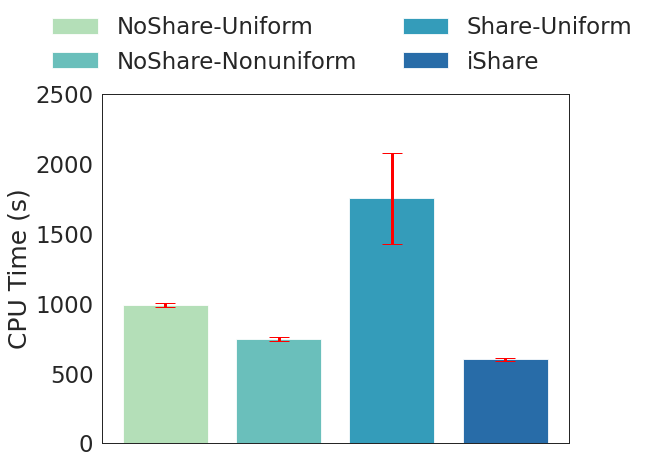

In [31]:
matplotlib.rcParams.update({'errorbar.capsize': 10})
sns.set_context("paper", rc = paper_rc, font_scale=2.6)

# Get only relevant data
df = total_data[
    (total_data["constraint_type"] == "nonUniform") &
    (total_data["query_set"] == "All TPC-H Queries")
][["execution_type", "time", "query_set"]]

# Massage data.
df = df.groupby(["execution_type", "query_set"]).agg(["mean", "max", "min"])
df.columns = [col[1] for col in df.columns.values]
df = df.reset_index()
df["err"] = df["max"] - df["min"]
df = df.drop(["max", "min"], axis=1)

# batch_df = batch_data.melt(id_vars=["execution_type"], value_vars=["Share (Batch)", "NoShare (Batch)"])
# batch_df = batch_df[batch_df["execution_type"] == "All TPC-H Queries"]
# batch_df["err"] = 0
# batch_df.columns = ["query_set", "execution_type", "mean", "err"]

# df = pd.concat([df, batch_df])

def grouped_barplot(df, cat, subcat, val, err):
    u = df[cat].unique()
    x = np.arange(len(u))
    subx = ["NoShare-Uniform", "NoShare-Nonuniform", "Share-Uniform", "iShare"]# + ["Share (Batch)", "NoShare (Batch)"]
    offsets = (np.arange(len(subx))-np.arange(len(subx)).mean())/(len(subx)+1.)
    width = np.diff(offsets).mean() * .75
    for i,gr in enumerate(subx):
        dfg = df[df[subcat] == gr]
        plt.bar(x+offsets[i], dfg[val].values, width=width, 
                label="{}".format(gr), yerr=dfg[err].values, ecolor="red")
    plt.xticks(x, u)

figsize = [x * 1 for x in [9,7]]
fig, ax = plt.subplots(1, figsize=figsize)

grouped_barplot(df, "query_set", "execution_type", "mean", "err")

ax.set_ylabel("CPU Time (s)")
ax.set_yticks(np.arange(0, 2500+1, 500))

ax.set_xticklabels([])
ax.set_xlabel("")

leg = ax.legend(
    bbox_to_anchor=(-0.15, 1.), 
    mode="extend",
    ncol=2,
    loc="lower left",
)
leg.get_frame().set_linewidth(0.0)

plt.tight_layout()
plt.savefig("../img/nonuniform.pdf", bbox_inches="tight")

In [32]:
batch_data = pd.read_csv("../cleaned_data/batch_execution.csv").dropna()
batch_data.columns = ["execution_type", "Share (Batch)", "NoShare (Batch)"]
for col in batch_data.columns[1:]:
    batch_data[col] /= 1000
    
batch_data["execution_type"] = batch_data["execution_type"].map({
    "10 TPC-H": "Ten TPC-H Queries",
    "22 TPC-H": "All TPC-H Queries",
})
batch_data

,execution_type,Share (Batch),NoShare (Batch)
0,Ten TPC-H Queries,318.290,435.221
1,All TPC-H Queries,512.864,662.824


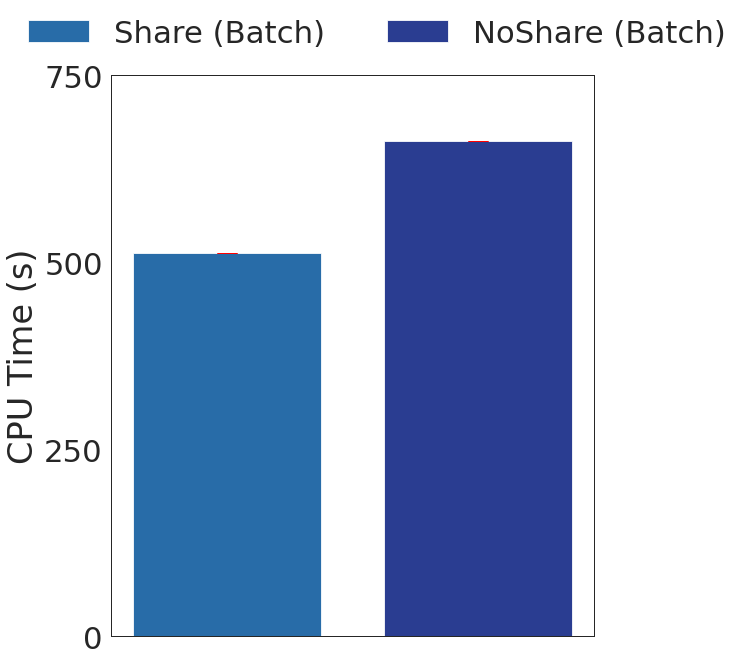

In [33]:
sns.set_context("paper", rc = paper_rc, font_scale=3.5)

batch_df = batch_data.melt(id_vars=["execution_type"], value_vars=["Share (Batch)", "NoShare (Batch)"])
batch_df = batch_df[batch_df["execution_type"] == "All TPC-H Queries"]
batch_df["err"] = 0
batch_df.columns = ["query_set", "execution_type", "mean", "err"]

def grouped_barplot(df, cat, subcat, val, err):
    u = df[cat].unique()
    x = np.arange(len(u))
    subx = ["Share (Batch)", "NoShare (Batch)"]
    offsets = (np.arange(len(subx))-np.arange(len(subx)).mean())/(len(subx)+1.)
    width = np.diff(offsets).mean()* .75
    for i,gr in enumerate(subx):
        dfg = df[df[subcat] == gr]
        plt.bar(x+offsets[i], dfg[val].values, width=width, color=color_palette[i+4],
                label="{}".format(gr), yerr=dfg[err].values, ecolor="red")
    plt.xticks(x, u)
    
figsize = [x for x in [10, 10]]
fig, ax = plt.subplots(1, figsize=figsize)

grouped_barplot(batch_df, "query_set", "execution_type", "mean", "err")

ax.set_ylabel("CPU Time (s)")
ax.set_yticks(np.arange(0, 751, 250))

leg = ax.legend(
    bbox_to_anchor=(-0.23, 1.), 
    mode="extend",
    ncol=2,
    loc="lower left",
)
leg.get_frame().set_linewidth(0.0)

ax.set_xticklabels([])
ax.set_xlabel("")

plt.tight_layout()
plt.savefig("../img/nonuniform_batch.pdf")

/home/totemtang/.local/lib/python3.8/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


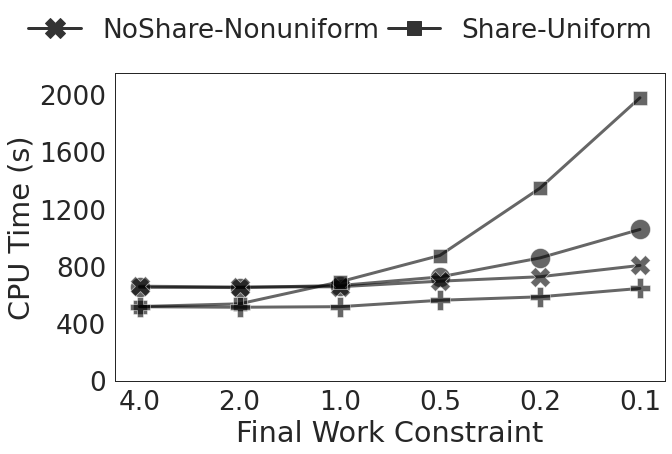

/home/totemtang/.local/lib/python3.8/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


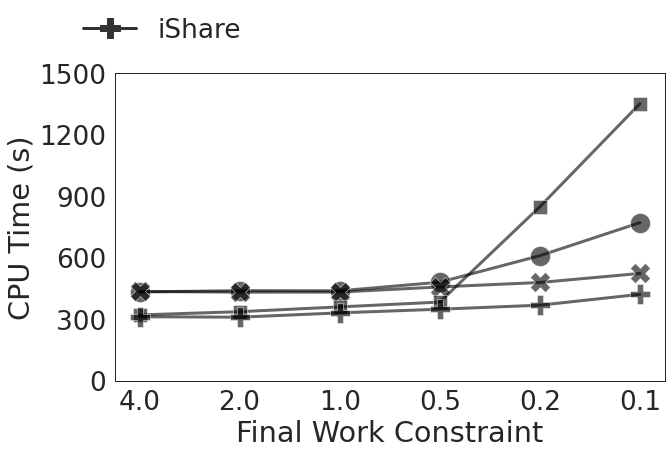

In [34]:
paper_rc = {'lines.linewidth': 3, 'lines.markersize': 20}                  
sns.set_context("paper", rc = paper_rc, font_scale=3)

query_set_filename = {
    "Ten TPC-H Queries": "ten_longest",
    "All TPC-H Queries": "all_tpch",
    "Ten TPC-H Queries Twice with Different Parameters": "ten_longest_twice",
}
execution_types = list(total_data["execution_type"].unique())

# Get only relevant data
df = total_data[total_data["constraint_type"] == "uniform"][["execution_type", "time", "query_set", "goal"]]

for i, query_set in enumerate(reversed(df["query_set"].unique())):
    query_set_df = df[df["query_set"] == query_set]
    label_to_axis = {
        0.1: 3,
        0.2: 2,
        0.5: 1,
        1.0: 0,
        2.0: -1,
        4.0: -2,
    }
    query_set_df["x"] = query_set_df["goal"].map(label_to_axis)
    
    figsize = [x * 1 for x in [10,7]]
    fig, ax = plt.subplots(1, figsize=figsize)

    ax = sns.lineplot(x="x", y="time", style="execution_type", ci=None, markers=True, dashes=False, color="black", alpha=0.6, data=query_set_df, ax=ax)
    
    if "All" in query_set:
        yticks = np.arange(0, 2001, 400)
        plt.ylim(0, 2150)
    elif "Ten"in query_set:
        yticks = np.arange(0, 1501, 300)
    
    ax.set_yticks(yticks)
    ax.set_xticks(np.arange(-2, 4))
    ax.set_xticklabels(reversed(list(label_to_axis.keys())))
    
    ax.set_ylabel("CPU Time (s)")
    ax.set_xlabel("Final Work Constraint")
    
    bbox_anchors = [
        [-0.2, 1.02, 1.22, 0.2],
        [-0.1, 1.02, 1, 0.2]
    ]
    
    handles, labels = ax.get_legend_handles_labels()
    leg = ax.legend(
        bbox_to_anchor=bbox_anchors[i], 
        loc="lower left", 
        mode="expand", 
        ncol=2,
        handles=handles[2*i+1:2*(i+1)+1], 
        labels=labels[2*i+1:2*(i+1)+1],
    )
    leg.get_frame().set_facecolor("none")
    leg.get_frame().set_linewidth(0.0)
    
    plt.tight_layout()
    plt.savefig("../img/uniform_{}.pdf".format(query_set_filename[query_set]), bbox_inches="tight")
    
    plt.show()
    plt.close()

# Manual data

In [35]:
manual_data = pd.read_csv("../cleaned_data/manual_data.csv")
manual_data

,execution_type,cpu_time,mean_percent,mean_time,max_percent,max_time,median_percent,median_time,min_percent,min_time
0,NoShare-Uniform,834.302,4.402254,0.156970,96.849584,3.453333,0,0.0,0,0.0
1,NoShare-Nonuniform,812.969,0.000000,0.000000,0.000000,0.000000,0,0.0,0,0.0
2,Share-Uniform,2326.429,29.706715,1.059242,653.547724,23.303333,0,0.0,0,0.0
3,iShare,648.561,0.000000,0.000000,0.000000,0.000000,0,0.0,0,0.0


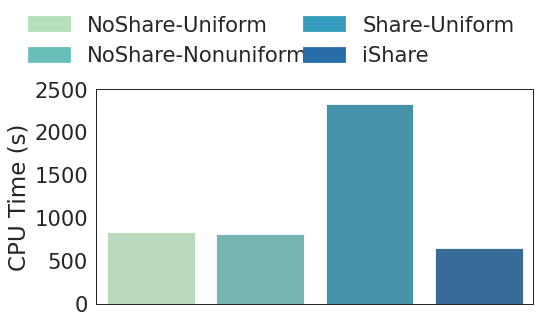

In [36]:
paper_rc = {'lines.linewidth': 3, 'lines.markersize': 12.5}                  
sns.set_context("paper", rc = paper_rc, font_scale=2.4)

fig = plt.figure(figsize=(8, 5))

ax = sns.barplot(y="cpu_time", x="execution_type", data=manual_data)

plt.tick_params(
    axis='x',          
    which='both',      
    bottom=False,
    top=False,         
    labelbottom=False)

ax.set_yticks(np.arange(0, 2501, 500))

ax.set_xlabel("")
ax.set_ylabel("CPU Time (s)")

labels = manual_data["execution_type"]
legend_handles = [mpatches.Patch(color=color_palette[i+1], label=label) for i, label in enumerate(labels)]
leg = ax.legend(
    bbox_to_anchor=(-0.2, 1.02, 1.2, 1), 
    loc="lower left", 
    mode="expand", 
    ncol=2,
    handles = legend_handles
)
leg.get_frame().set_facecolor("none")
leg.get_frame().set_linewidth(0.0)

plt.tight_layout()
plt.savefig("../img/manual.pdf")

# Unsharing

In [37]:
total_data = pd.read_csv("../cleaned_data/total_data.csv")
total_data = total_data[
    (total_data["constraint_type"] == "uniform") &
    (total_data["query_set"] == "Ten TPC-H Queries Twice with Different Parameters")
]
total_data.head()

,timestamp,execution_type,time,order,goal,query_set,constraint_type,q15
2,09-01-04:18:56,NoShare-Uniform,953.866,0,0.5,Ten TPC-H Queries Twice with Different Parameters,uniform,True
9,09-01-08:18:53,NoShare-Uniform,880.394,0,1.0,Ten TPC-H Queries Twice with Different Parameters,uniform,True
21,08-31-23:09:51,NoShare-Uniform,1110.569,0,0.2,Ten TPC-H Queries Twice with Different Parameters,uniform,True
25,09-13-16:24:32,NoShare-Uniform,865.761,0,4.0,Ten TPC-H Queries Twice with Different Parameters,uniform,True
29,09-01-05:49:57,NoShare-Uniform,889.131,0,1.0,Ten TPC-H Queries Twice with Different Parameters,uniform,True


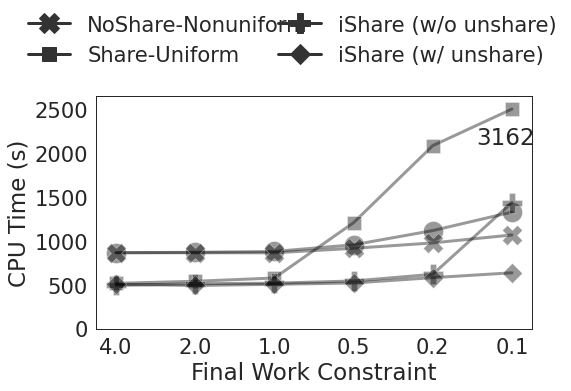

In [38]:
paper_rc = {'lines.linewidth': 3, 'lines.markersize': 20}                  
sns.set_context("paper", rc = paper_rc, font_scale=2.4)

size = [x*1 for x in [8, 6]]
plt.subplots(1, figsize=size)

ymax_val = 2500

label_to_axis = {
        0.1: 3,
        0.2: 2,
        0.5: 1,
        1.0: 0,
        2.0: -1,
        4.0: -2,
    }
total_data["x"] = total_data["goal"].map(label_to_axis)
total_data["capped time"] = total_data["time"].map(lambda x: min(x, ymax_val))

ax = sns.lineplot(x="x", y="capped time", style="execution_type", ci=None, markers=True, dashes=False, color="black", alpha=0.4, data=total_data)

for i, row in total_data[total_data["time"] != total_data["capped time"]].groupby("goal").mean().iterrows():
    ax.text(x=row["x"]-0.45, y=row["capped time"]-400, s=int(row["time"]))

plt.ylim(0, ymax_val+150)

ax.set_yticks(np.arange(0, ymax_val+1, 500))
ax.set_xticks(list(label_to_axis.values()))
ax.set_xticklabels(list(label_to_axis.keys()))

ax.set_ylabel("CPU Time (s)")
ax.set_xlabel("Final Work Constraint")

handles, labels = ax.get_legend_handles_labels()
leg = ax.legend(
    bbox_to_anchor=(-0.2, 1.05, 1.3, 1.02),
    ncol=2,
    mode="expand",
    loc="lower left",
    handles=handles[1:], 
    labels=labels[1:],
)
leg.get_frame().set_facecolor("none")
leg.get_frame().set_linewidth(0.0)

plt.tight_layout()
plt.savefig("../img/unshare.pdf")

# Overhead

In [39]:
opt_data = pd.read_csv("../cleaned_data/optimization.csv")
opt_data.head()

,max_pace,execution_type,time
0,10,NoShare-Uniform,0.262
1,20,NoShare-Uniform,0.448
2,30,NoShare-Uniform,0.879
3,40,NoShare-Uniform,1.202
4,50,NoShare-Uniform,1.682


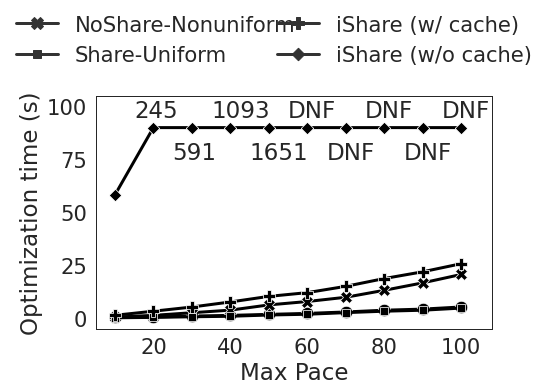

In [40]:
paper_rc = {'lines.linewidth': 3, 'lines.markersize': 12.5}                  
sns.set_context("paper", rc = paper_rc, font_scale=2.4)

size = [x*1 for x in [7.5, 6]]
fig = plt.figure(figsize=size)

opt_data["capped time"] = opt_data["time"].map(lambda x: min(x, 90))

ax = sns.lineplot(x="max_pace", y="capped time", style="execution_type", ci=None, markers=True, dashes=False, color="black", data=opt_data)

for i, row in opt_data[opt_data["time"] != opt_data["capped time"]].iterrows():
    if row["time"] == 30*60:
        text = "DNF"
    else:
        text = int(row["time"])
    top = 5 if i%2 == 1 else -15
    ax.text(x=row["max_pace"]-5, y=row["capped time"]+top, s=text)

handles, labels = ax.get_legend_handles_labels()
leg = ax.legend(
    bbox_to_anchor=(-0.25, 1.05, 1.4, 1.02),
    ncol=2,
    mode="expand",
    loc="lower left",
    handles=handles[1:], 
    labels=labels[1:],
)
leg.get_frame().set_facecolor("none")
leg.get_frame().set_linewidth(0.0)

ax.set_ylabel("Optimization time (s)")
ax.set_xlabel("Max Pace")

plt.ylim(-5, 105)
ax.set_yticks(np.arange(0, 100+1, 25))

plt.xlim(5, 108)

plt.tight_layout()
plt.savefig("../img/overhead.pdf", bbox_inches="tight")
plt.show()
plt.close()

# Overhead Breakdown

                 Find Nonuniform Pace  Estimate Unsharing  \
Query Set                                                   
22 TPC-H                       25.560               0.066   
10 TPC-H                       10.524               0.017   
Double 10 TPC-H                42.502               0.077   

                 Incrementally Adjust Pace  
Query Set                                   
22 TPC-H                              0.00  
10 TPC-H                              0.00  
Double 10 TPC-H                       0.48  


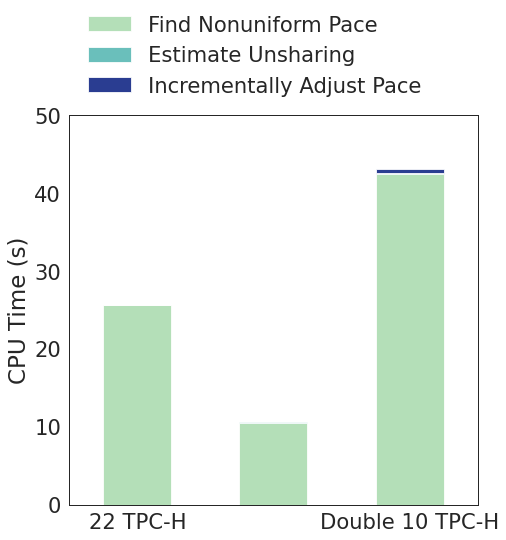

In [41]:
paper_rc = {'lines.linewidth': 3, 'lines.markersize': 12.5}                  
sns.set_context("paper", rc = paper_rc, font_scale=2.4)

size = [x*1 for x in [7.5, 8]]
fig, ax = plt.subplots(1, figsize=size)

overhead = pd.read_csv("../cleaned_data/optimization_overhead.csv", index_col=0)
overhead = overhead.drop("Total", axis=1)
overhead = overhead.set_index("Query Set")

# df.set_index("").T.plot(kind='bar', stacked=True)
print(overhead)
overhead.plot(kind="bar", stacked=True, color=[color_palette[x] for x in [1, 2, 5]], ax=ax)

ax.tick_params(axis='x', rotation=0)

ax.set_yticks(np.arange(0, 50+1, 10))
ax.set_xticks([0, 0.9, 2])

ax.set_ylabel("CPU Time (s)")
ax.set_xlabel("")

handles, labels = ax.get_legend_handles_labels()
leg = ax.legend(
    bbox_to_anchor=(0, 1),
    ncol=1,
    mode="expand",
    loc="lower left",
)
leg.get_frame().set_facecolor("none")
leg.get_frame().set_linewidth(0.0)

plt.tight_layout()
plt.savefig("../img/optimization_overhead.pdf")

# Micro data

In [42]:
micro_data = pd.read_csv("../cleaned_data/micro_data.csv")
micro_data["share"] = micro_data["execution_type"].map(lambda x: "NoShare" if "NoShare" in x else "Share")
micro_data["execution_type"] = micro_data["execution_type"].str.replace(r"\(.*\)","").str.strip()
micro_data.tail()

<ipython-input-42-ef51706de957>:3: FutureWarning: The default value of regex will change from True to False in a future version.
  micro_data["execution_type"] = micro_data["execution_type"].str.replace(r"\(.*\)","").str.strip()


,timestamp,execution_type,time,pairing,goal,share
151,09-07-00:24:21,iShare,54.331,pairC,0.2,Share
152,09-07-00:34:14,iShare,54.719,pairC,0.2,Share
153,09-06-23:38:32,iShare,63.035,pairC,0.1,Share
154,09-06-23:51:15,iShare,62.111,pairC,0.1,Share
155,09-07-00:03:46,iShare,63.457,pairC,0.1,Share


/home/totemtang/.local/lib/python3.8/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


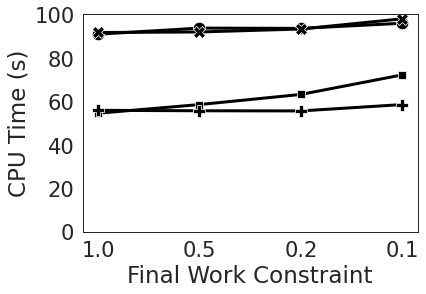

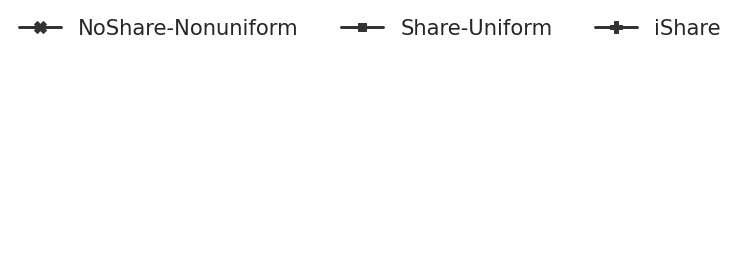

/home/totemtang/.local/lib/python3.8/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


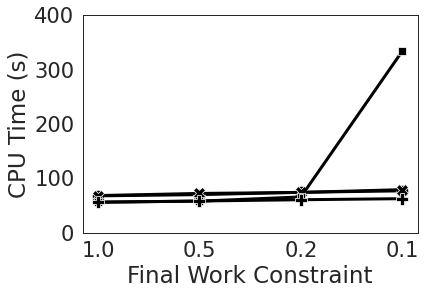

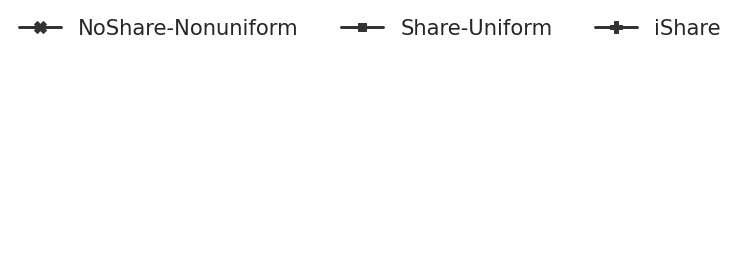

/home/totemtang/.local/lib/python3.8/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


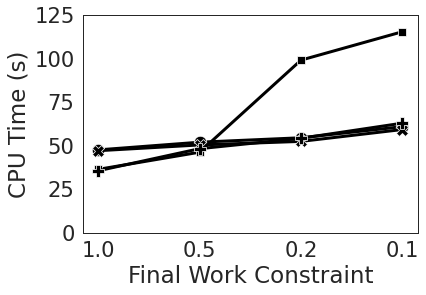

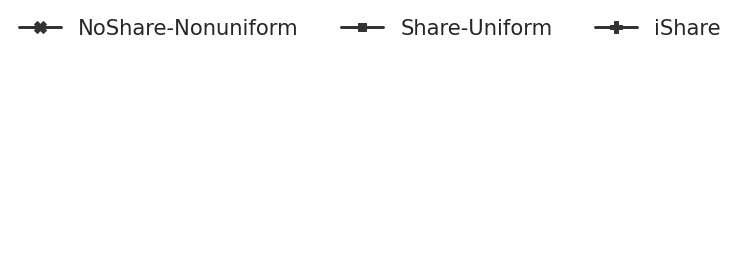

In [43]:
paper_rc = {'lines.linewidth': 3, 'lines.markersize': 12.5}                  
sns.set_context("paper", rc = paper_rc, font_scale=2.4)

for pairing in micro_data["pairing"].unique():
    fig, ax = plt.subplots(1)
    fig_legend, axi = plt.subplots(1)
    
    df = micro_data[micro_data["pairing"] == pairing]
    df["x"] = df["goal"].map({
        0.1: 3,
        0.2: 2,
        0.5: 1,
        1.0: 0,
    })
    
    ax = sns.lineplot(x="x", y="time", style="execution_type", ci=None, markers=True, dashes=False, color="black", data=df, ax=ax)

#     ax.set_yticks(np.arange(0, 3501, 500))
    ax.set_xticks(range(4))
    ax.set_xticklabels([1.0, 0.5, 0.2, 0.1])
    
    if pairing == "pairA":
        ymax = 100
        ysteps = 20
    elif pairing == "pairB":
        ymax = 400
        ysteps = 100
    elif pairing == "pairC":
        ymax = 125
        ysteps = 25
        
    plt.ylim(0, ymax+1)
    ax.set_yticks(np.arange(0, ymax+1, ysteps))

    ax.set_ylabel("CPU Time (s)")
    ax.set_xlabel("Final Work Constraint")

    handles, labels = ax.get_legend_handles_labels()
    leg = fig_legend.legend(handles=handles[1:], labels=labels[1:], loc="upper left", ncol=4, frameon=False)
    axi.xaxis.set_visible(False)
    axi.yaxis.set_visible(False)
    fig_legend.canvas.draw()
    sns.despine(left=True, bottom=True, right=True, ax=axi)
    
    legend = ax.legend()
    legend.remove()

    plt.tight_layout()
    fig.savefig("../img/micro_{}.pdf".format(pairing), bbox_inches="tight")
    fig_legend.savefig("../img/micro_legend.pdf", bbox_inches="tight")
    plt.show()
    plt.close()

In [44]:
micro_data.head()

,timestamp,execution_type,time,pairing,goal,share
0,09-06-19:49:03,NoShare-Uniform,91.443,pairA,1.0,NoShare
1,09-06-19:57:34,NoShare-Uniform,90.494,pairA,1.0,NoShare
2,09-06-20:06:15,NoShare-Uniform,90.568,pairA,1.0,NoShare
3,09-06-19:22:36,NoShare-Uniform,95.234,pairA,0.5,NoShare
4,09-06-19:31:23,NoShare-Uniform,91.446,pairA,0.5,NoShare


In [45]:
df = micro_data[
    (micro_data["execution_type"] != "iShare") &
    (micro_data["pairing"] != "pairB") &
    ((micro_data["goal"] == 1.0) | (micro_data["goal"] == 0.1) | (micro_data["goal"] == 2.0))
]
df["execution_type"] = df["execution_type"].map(lambda x: "NoShare" if "NoShare" in x else "Share")
df = df.groupby(["execution_type", "pairing", "goal"]).mean().reset_index()
df

# ax = sns.barplot(x="execution_type", y="time", data=df)

# labels = df["execution_type"]
# legend_labels = [mpatches.Patch(color=color_palette[i], label=label) for i, label in enumerate(labels)]
# plt.legend(handles=legend_labels)

# plt.tick_params(
#     axis='x',          
#     which='both',      
#     bottom=False,
#     top=False,         
#     labelbottom=False)

# ax.set_xlabel("")
# ax.set_ylabel("CPU Time (s)")

# plt.title("1.0")

/home/totemtang/.local/lib/python3.8/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


,execution_type,pairing,goal,time
0,NoShare,pairA,0.1,96.897833
1,NoShare,pairA,1.0,91.223667
2,NoShare,pairA,2.0,91.520000
3,NoShare,pairC,0.1,60.029607
4,NoShare,pairC,1.0,47.252224
5,NoShare,pairC,2.0,47.047667
6,Share,pairA,0.1,72.107667
7,Share,pairA,1.0,54.441333
8,Share,pairA,2.0,51.702667
9,Share,pairC,0.1,115.431333


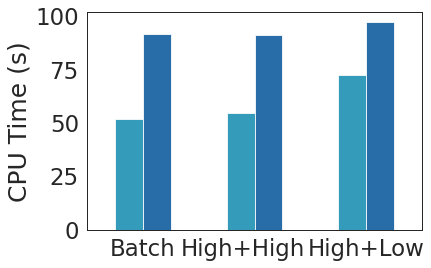

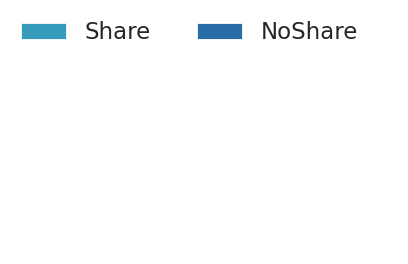

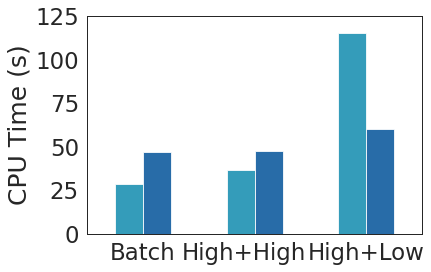

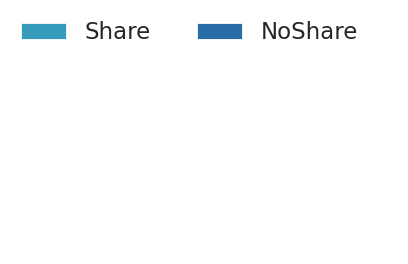

In [46]:
paper_rc = {'lines.linewidth': 3, 'lines.markersize': 12.5}
sns.set_context("paper", rc = paper_rc, font_scale=2.6)

# micro_batch = pd.DataFrame([
#     ["Share", "pairA", 200, 10],
#     ["NoShare", "pairA", 200, 10],
#     ["Share", "pairC", 200, 10],
#     ["NoShare", "pairC", 200, 10],
# ])
# micro_batch.columns = ["execution_type", "pairing", "goal", "time"]

data = df #pd.concat([df, micro_batch])

for pairing in data["pairing"].unique():
    fig, ax = plt.subplots(1)
    fig_legend, axi = plt.subplots(1)
    
#     ax = sns.barplot(x="goal", y="time", hue="execution_type", ci=None, data=data[data["pairing"] == pairing])
    temp_data = data[data["pairing"] == pairing]
    temp_data = temp_data.drop("pairing", axis=1)
    temp_data = temp_data.pivot(columns="execution_type", index="goal")
    temp_data.columns = temp_data.columns.get_level_values(1)
    temp_data = temp_data[["Share", "NoShare"]]
    temp_data = temp_data.sort_index(ascending=False)
    ax = temp_data.plot(kind="bar", legend=False, ax=ax, color=color_palette[3:5])
    
    ax.tick_params(axis='x', rotation=0)
    ax.set_xticks([0, 0.9, 2])
    ax.set_xticklabels(["Batch", "High+High", "High+Low"])
    ax.set_xlabel("")
    
    ax.set_ylabel("CPU Time (s)")
    
    if pairing == "pairC":
        ax.set_yticks(np.arange(0, 125+1, 25))
    else:
        ax.set_yticks(np.arange(0, 100+1, 25))
    
    handles, labels = ax.get_legend_handles_labels()
    leg = fig_legend.legend(handles=handles[0:], labels=labels[0:], loc="upper left", ncol=2, frameon=False)
    axi.xaxis.set_visible(False)
    axi.yaxis.set_visible(False)
    fig_legend.canvas.draw()
    sns.despine(left=True, bottom=True, right=True, ax=axi)

    plt.tight_layout()
    fig.savefig("../img/motiviation_{}.pdf".format(pairing), bbox_inches="tight")
    fig_legend.savefig("../img/motivation_legend.pdf", bbox_inches="tight")
    
    plt.show()
    
    plt.close()